In [14]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [3]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [4]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

<Axes: title={'center': 'Mean final price per operator distribution'}>

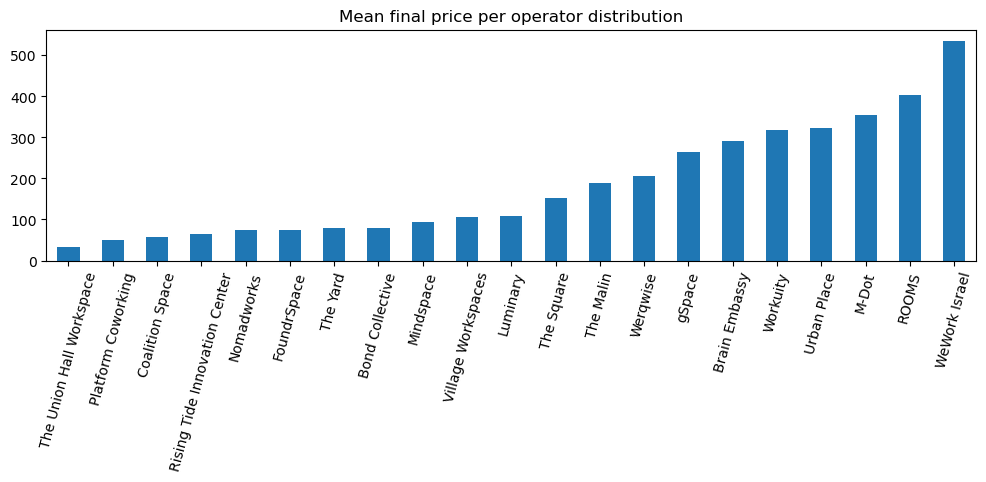

In [5]:
filtered_df.groupby('operator_name').mean(numeric_only=True)['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution")

In [8]:
filtered_df.groupby('operator_name').sum(numeric_only=True)['final_price'].sort_values(ascending=False)


operator_name
WeWork Israel                    2279715.41
Mindspace                         862619.47
The Yard                          269103.00
The Malin                         256210.25
Urban Place                       201909.38
Brain Embassy                     176435.66
Werqwise                          115175.50
ROOMS                             105019.20
Luminary                           84839.75
Nomadworks                         69556.50
M-Dot                              35695.53
Bond Collective                    30043.75
FoundrSpace                        10972.50
Village Workspaces                  7271.60
gSpace                              1850.00
Rising Tide Innovation Center       1847.50
Workuity                             950.00
Platform Coworking                   815.00
The Square                           760.00
Coalition Space                      455.00
The Union Hall Workspace             395.00
Name: final_price, dtype: float64

In [10]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()


22696

In [11]:
filtered_df['date'].describe()


count          22696
unique           821
top       2023-06-21
freq             100
Name: date, dtype: object

In [12]:
# Number of unique operators
filtered_df['operator_id'].nunique()


21

In [13]:
fdf = filtered_df

# Features 

In [15]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])
monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

### Monetary value per country

In [ ]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()

In [17]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum(numeric_only=True))

In [18]:
country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

In [19]:
country_totals

,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340928.25
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


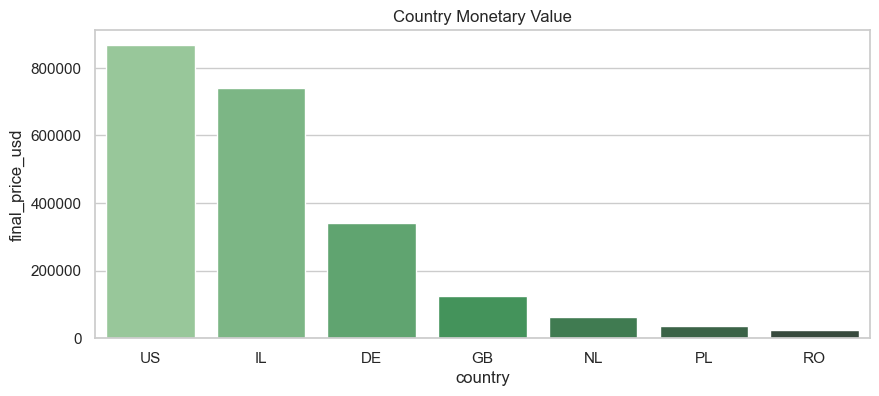

In [20]:
plt.figure(figsize=(10,4))

sns.set(style='whitegrid', color_codes=True)

pal = sns.color_palette('Greens_d', len(country_totals))

# Swap x and y for vertical bars
sns.barplot(x=country_totals['country'], y=country_totals['final_price_usd'], palette=pal)

plt.title('Country Monetary Value')
plt.xticks()
plt.show()

### Number of operators in each country 

In [22]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)

country_operator                                                                                                               

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

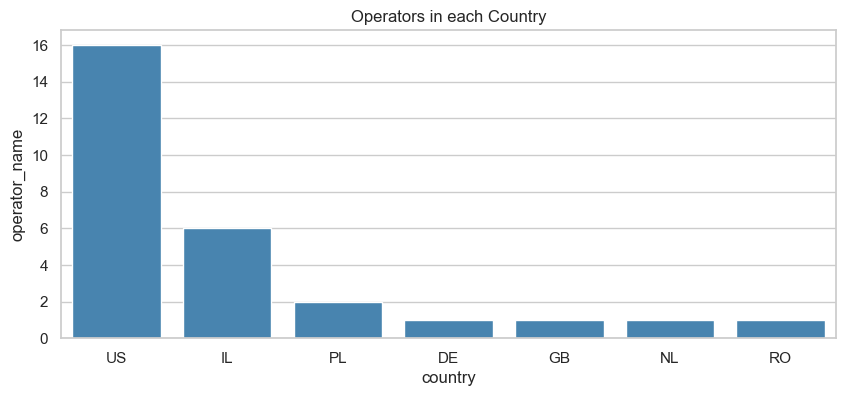

In [23]:
plt.figure(figsize = (10, 4))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(x=country_operator['country'], y=country_operator['operator_name'], palette=pal)

plt.title('Operators in each Country')

### Time series  

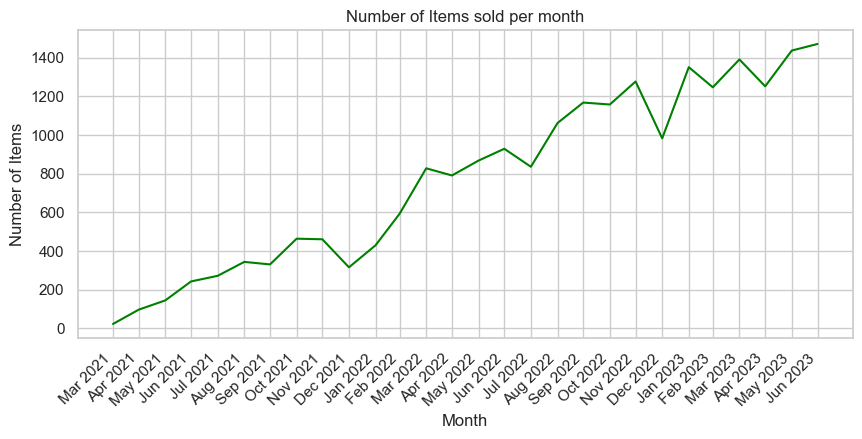

In [24]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

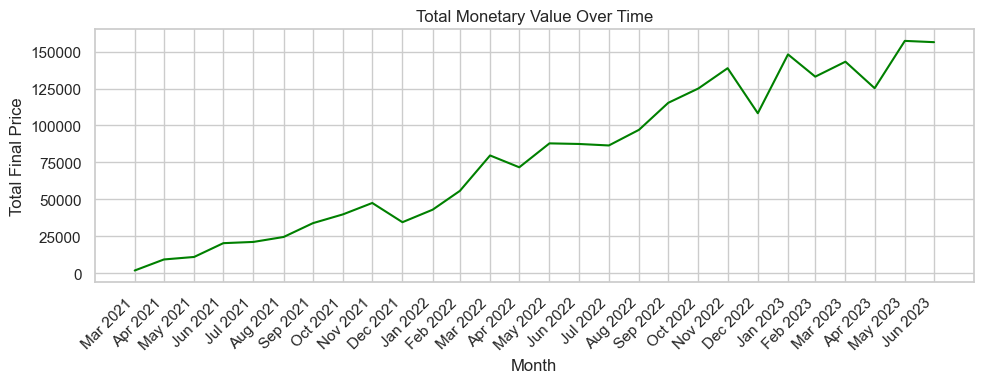

In [27]:
# Resample by month and sum the final_price
df_group = fdf.resample('M', on='date')['final_price_usd'].sum()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Total_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Total Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

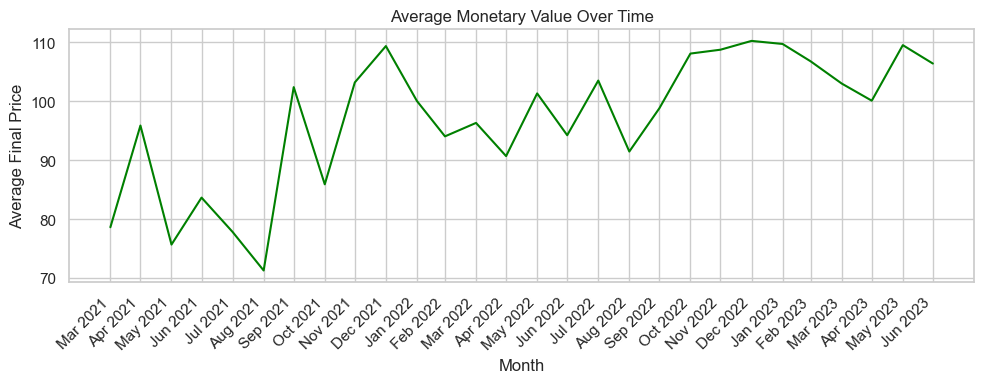

In [28]:
# Resample by month and sum the final_price
df_group = fdf.resample('M', on='date')['final_price_usd'].mean()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Average_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Average_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Average Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Average Final Price')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

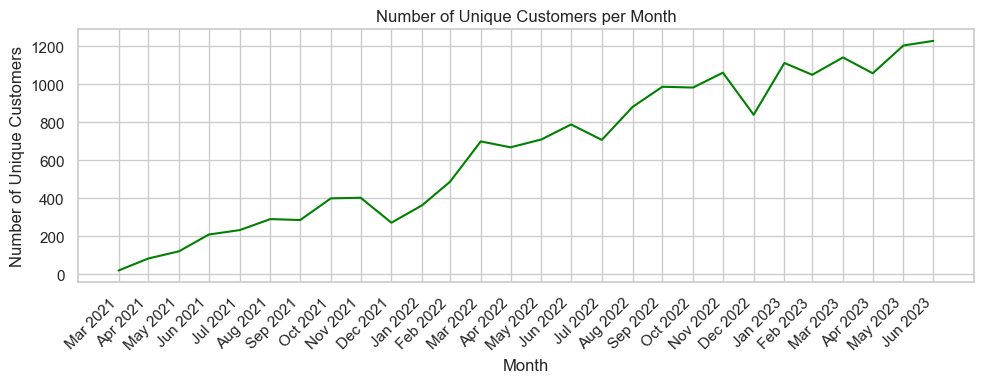

In [26]:
# Resample by month and count the unique emails
df_group = fdf.resample('M', on='date').customer_email.nunique()
df_group = df_group.reset_index()
df_group.columns = ['Month', 'Number_of_unique_customers']

plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group['Month'], y=df_group['Number_of_unique_customers'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Unique Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')

plt.xticks(df_group['Month'], df_group['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# RFM Function

In [29]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [30]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
    #df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df

In [31]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [32]:
rfm_by_full_name

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,27,85,21,1362.50,20,0.050000,0.247059
1,Bond Collective-US-DC-Washington,98,9,5,125.00,3,0.666667,0.555556
2,Bond Collective-US-IL-Chicago,24,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,24,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,25,80,59,4143.75,49,0.142857,0.737500
...,...,...,...,...,...,...,...,...
57,Werqwise-US-CA-San Francisco,26,595,340,62219.75,267,0.168539,0.571429
58,Werqwise-US-CA-San Mateo,24,541,185,36028.50,150,0.133333,0.341959
59,Workuity-US-AZ-Chandler,27,2,3,950.00,2,0.500000,1.500000
60,gSpace-US-CT-Fairfield,55,43,3,750.00,2,0.500000,0.069767


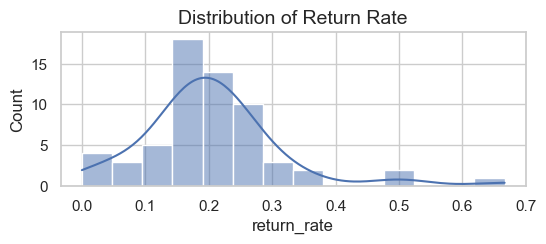

In [36]:
return_rate = rfm_by_full_name['return_rate'].copy()
plt.figure(figsize=(6, 2))
sns.histplot(return_rate, kde=True)
plt.title(f'Distribution of Return Rate', fontsize=14)
plt.show()

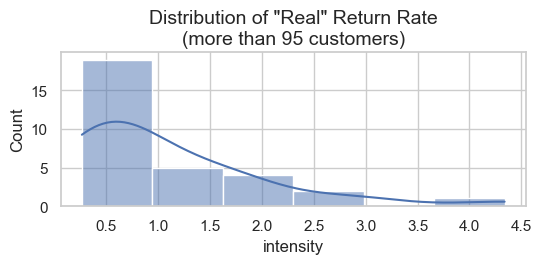

In [44]:
more_than_median =rfm_by_full_name[rfm_by_full_name['total_customers']>rfm_by_full_name['total_customers'].median()].copy()
plt.figure(figsize=(6, 2))
sns.histplot(data=more_than_median['intensity'], kde=True)
plt.title(f'Distribution of "Real" Return Rate\n(more than 95 customers)', fontsize=14)
plt.show()

In [45]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,62.000000,62.000000,62.000000,62.00000,62.000000,62.000000,62.000000
mean,30.983871,446.338710,350.548387,35493.55871,234.564516,0.204469,0.700075
std,17.701988,297.078669,524.059616,55098.78111,344.225032,0.111132,0.797688
min,24.000000,1.000000,1.000000,125.00000,1.000000,0.000000,0.036232
25%,24.000000,140.250000,34.500000,3759.32250,25.250000,0.154600,0.237086
50%,25.000000,488.500000,142.000000,11180.08000,94.500000,0.198697,0.381385
75%,27.000000,706.250000,453.750000,39026.84750,327.750000,0.249282,0.843671
max,122.000000,842.000000,2452.000000,312877.81000,1658.000000,0.666667,4.339552


In [47]:
rfm_by_full_name[rfm_by_full_name['return_rate']==2452]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
14,Mindspace-DE-Berlin,24,831,2452,173148.61,1520,0.250658,2.950662


# Segmentation

In [50]:
rfm_by_full_name[rfm_by_full_name['return_rate'] >= 0.66]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
1,Bond Collective-US-DC-Washington,98,9,5,125.0,3,0.666667,0.555556


In [51]:
rfm_by_full_name[rfm_by_full_name['monetary'] == 312877.81000]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
56,WeWork Israel-IL-Tel Aviv,25,694,1925,312877.81,1266,0.21406,2.773775


In [52]:
rfm_by_full_name[rfm_by_full_name['recency'] == 122.000000]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
50,Village Workspaces-US-CA-Los Angeles,122,173,67,6947.6,54,0.166667,0.387283


In [54]:
rfm_by_full_name[rfm_by_full_name['intensity'] >= 4.00]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
46,The Yard-US-NY-New York,24,536,2326,175776.5,1658,0.168275,4.339552


In [61]:
def segment_customer(row):
    if row['lifetime'] < 400 and row['monetary'] < 100000:
        return 'not_blooming'
    elif row['lifetime'] >= 400 and row['monetary'] < 100000:
        return 'loyalist'
    elif row['monetary'] >= 100000:
        return 'big_fish'
    else:
        return 'other'

rfm_by_full_name['seg'] = rfm_by_full_name.apply(segment_customer, axis=1)


In [62]:
rfm_by_full_name

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
0,Bond Collective-US-CA-Los Angeles,27,85,21,1362.50,20,0.050000,0.247059,not_blooming
1,Bond Collective-US-DC-Washington,98,9,5,125.00,3,0.666667,0.555556,not_blooming
2,Bond Collective-US-IL-Chicago,24,91,46,5650.00,43,0.069767,0.505495,not_blooming
3,Bond Collective-US-NY-Brooklyn,24,89,173,9650.00,136,0.198529,1.943820,not_blooming
4,Bond Collective-US-NY-New York,25,80,59,4143.75,49,0.142857,0.737500,not_blooming
...,...,...,...,...,...,...,...,...,...
57,Werqwise-US-CA-San Francisco,26,595,340,62219.75,267,0.168539,0.571429,loyalist
58,Werqwise-US-CA-San Mateo,24,541,185,36028.50,150,0.133333,0.341959,loyalist
59,Workuity-US-AZ-Chandler,27,2,3,950.00,2,0.500000,1.500000,not_blooming
60,gSpace-US-CT-Fairfield,55,43,3,750.00,2,0.500000,0.069767,not_blooming


In [63]:
rfm_by_full_name['seg'].value_counts(sort=False)

not_blooming    27
loyalist        29
big_fish         6
Name: seg, dtype: int64

In [84]:
seg_merge_fdf = fdf.merge(rfm_by_full_name[['operator', 'seg']], 
                       left_on='operator_full_name', 
                       right_on='operator')


In [85]:
big_fish_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'big_fish']
loyalist_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'loyalist']
not_blooming_fdf = seg_merge_fdf[seg_merge_fdf['seg'] == 'not_blooming']


In [86]:
big_fish_monetary = big_fish_fdf[['date', 'final_price_usd']]
loyalist_monetary = loyalist_fdf[['date', 'final_price_usd']]
not_blooming_monetary = not_blooming_fdf[['date', 'final_price_usd']]


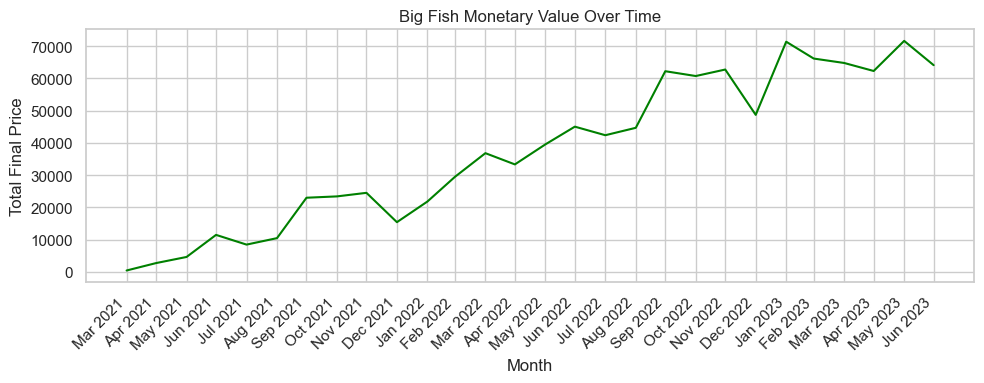

In [87]:
# Resample by month and sum the final_price
big_fish_monetary = big_fish_monetary.resample('M', on='date')['final_price_usd'].sum()
big_fish_monetary = big_fish_monetary.reset_index()
big_fish_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Big Fish Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

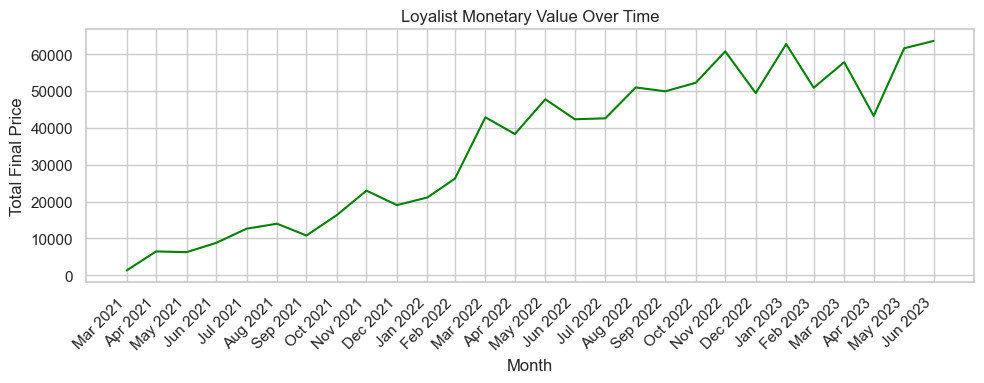

In [88]:
# Resample by month and sum the final_price
loyalist_monetary = loyalist_monetary.resample('M', on='date')['final_price_usd'].sum()
loyalist_monetary = loyalist_monetary.reset_index()
loyalist_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Loyalist Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(loyalist_monetary['Month'], loyalist_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

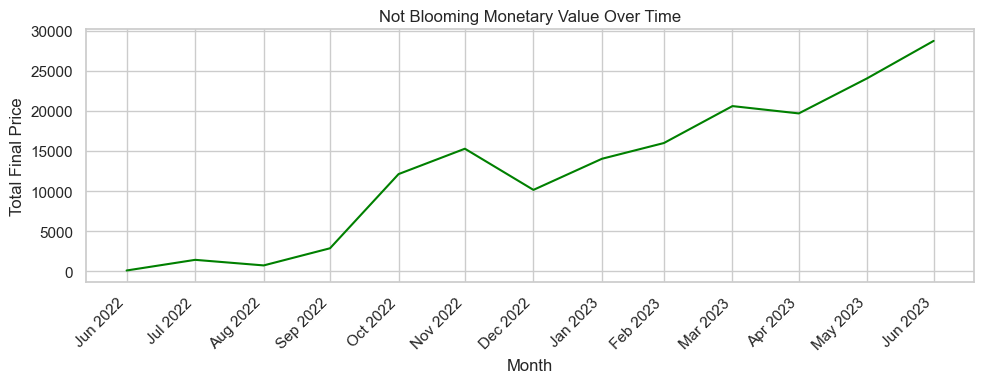

In [89]:
# Resample by month and sum the final_price
not_blooming_monetary = not_blooming_monetary.resample('M', on='date')['final_price_usd'].sum()
not_blooming_monetary = not_blooming_monetary.reset_index()
not_blooming_monetary.columns = ['Month', 'Total_final_price']

plt.figure(figsize=(10, 4))
sns.lineplot(x=not_blooming_monetary['Month'], y=not_blooming_monetary['Total_final_price'], color = 'Green')

# Set the chart title and axis labels
plt.title('Not Blooming Monetary Value Over Time')
plt.xlabel('Month')
plt.ylabel('Total Final Price')

plt.xticks(not_blooming_monetary['Month'], not_blooming_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.show()

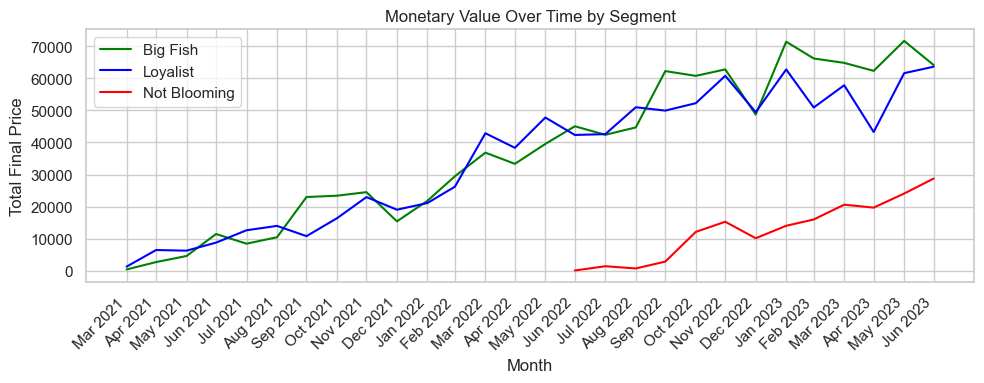

In [90]:
# Set up the figure and axis
plt.figure(figsize=(10, 4))

# Big Fish segment
sns.lineplot(x=big_fish_monetary['Month'], y=big_fish_monetary['Total_final_price'], label='Big Fish', color='Green')

# Loyalist segment
sns.lineplot(x=loyalist_monetary['Month'], y=loyalist_monetary['Total_final_price'], label='Loyalist', color='Blue')

# Not Blooming segment
sns.lineplot(x=not_blooming_monetary['Month'], y=not_blooming_monetary['Total_final_price'], label='Not Blooming', color='Red')

# Set the chart title, axis labels, and other aesthetics
plt.title('Monetary Value Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Total Final Price')
plt.xticks(big_fish_monetary['Month'], big_fish_monetary['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()  # Display the legend
plt.tight_layout()
plt.show()


In [76]:
print(big_fish_fdf.columns)
print(loyalist_fdf.columns)
print(not_blooming_fdf.columns)

Index(['Month', 'Total_final_price'], dtype='object')
Index(['Month', 'Total_final_price'], dtype='object')
Index(['Month', 'Total_final_price'], dtype='object')


In [93]:
big_fish_frequency = big_fish_fdf[['date', 'operator_full_name']]
loyalist_frequency = loyalist_fdf[['date', 'operator_full_name']]
not_blooming_frequency = not_blooming_fdf[['date', 'operator_full_name']]

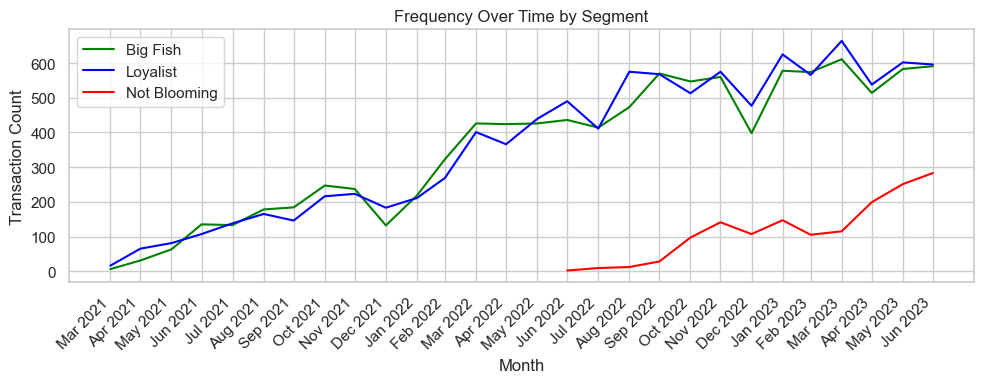

In [98]:
big_fish_freq = big_fish_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
loyalist_freq = loyalist_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')
not_blooming_freq = not_blooming_frequency.resample('M', on='date')['operator_full_name'].size().reset_index(name='Frequency')

# Set up the figure and axis
plt.figure(figsize=(10, 4))

# Big Fish segment frequency
sns.lineplot(x=big_fish_freq['date'], y=big_fish_freq['Frequency'], label='Big Fish', color='Green')

# Loyalist segment frequency
sns.lineplot(x=loyalist_freq['date'], y=loyalist_freq['Frequency'], label='Loyalist', color='Blue')

# Not Blooming segment frequency
sns.lineplot(x=not_blooming_freq['date'], y=not_blooming_freq['Frequency'], label='Not Blooming', color='Red')

# Set the chart title, axis labels, and other aesthetics
plt.title('Frequency Over Time by Segment')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(big_fish_freq['date'], big_fish_freq['date'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.legend()  # Display the legend
plt.tight_layout()
plt.show()


In [105]:
loyalist_rfm = rfm_by_full_name[rfm_by_full_name['seg'] == 'loyalist'].copy()

In [107]:
loyalist_rfm.sort_values(by='intensity', ascending=False)

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
12,Luminary-US-NY-New York,24,403,709,71605.75,437,0.237986,1.759305,loyalist
45,The Yard-US-NY-Brooklyn,24,535,688,51423.50,531,0.171375,1.285981,loyalist
32,Nomadworks-US-NY-New York,25,709,908,65939.50,666,0.159159,1.280677,loyalist
54,WeWork Israel-IL-Jerusalem,25,634,617,69975.75,391,0.235294,0.973186,loyalist
52,WeWork Israel-IL-Haifa,25,639,591,66079.69,348,0.247126,0.924883,loyalist
25,Mindspace-NL-Amsterdam,24,834,713,51045.18,514,0.157588,0.854916,loyalist
49,Urban Place-IL-Tel Aviv,26,463,375,31261.05,234,0.217949,0.809935,loyalist
30,Mindspace-US-DC-Washington,24,825,615,37886.30,470,0.189362,0.745455,loyalist
16,Mindspace-DE-Hamburg,24,817,591,39407.03,414,0.202899,0.723378,loyalist
8,Brain Embassy-PL-Warsaw,24,698,482,30368.67,359,0.200557,0.690544,loyalist


In [108]:
loyalist_rfm.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,26.241379,677.551724,352.620690,33888.727586,243.620690,0.209003,0.549988
std,3.699953,136.761415,234.863701,21051.697988,169.023543,0.062284,0.407321
min,24.000000,403.000000,48.000000,6589.400000,25.000000,0.079545,0.060530
25%,24.000000,586.000000,193.000000,17270.000000,124.000000,0.171375,0.329600
50%,25.000000,697.000000,289.000000,30368.670000,188.000000,0.200557,0.417526
75%,26.000000,817.000000,591.000000,51045.180000,359.000000,0.247126,0.745455
max,41.000000,842.000000,908.000000,71605.750000,666.000000,0.363636,1.759305


In [112]:
recent_loyalist_rfm = loyalist_rfm[loyalist_rfm['recency'] == 24]

In [113]:
recent_loyalist_rfm

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
7,Brain Embassy-IL-Tel Aviv,24,697,97,9314.35,62,0.225806,0.139168,loyalist
8,Brain Embassy-PL-Warsaw,24,698,482,30368.67,359,0.200557,0.690544,loyalist
12,Luminary-US-NY-New York,24,403,709,71605.75,437,0.237986,1.759305,loyalist
16,Mindspace-DE-Hamburg,24,817,591,39407.03,414,0.202899,0.723378,loyalist
25,Mindspace-NL-Amsterdam,24,834,713,51045.18,514,0.157588,0.854916,loyalist
26,Mindspace-NL-Utrecht,24,837,222,12211.71,168,0.136905,0.265233,loyalist
30,Mindspace-US-DC-Washington,24,825,615,37886.30,470,0.189362,0.745455,loyalist
45,The Yard-US-NY-Brooklyn,24,535,688,51423.50,531,0.171375,1.285981,loyalist
58,Werqwise-US-CA-San Mateo,24,541,185,36028.50,150,0.133333,0.341959,loyalist


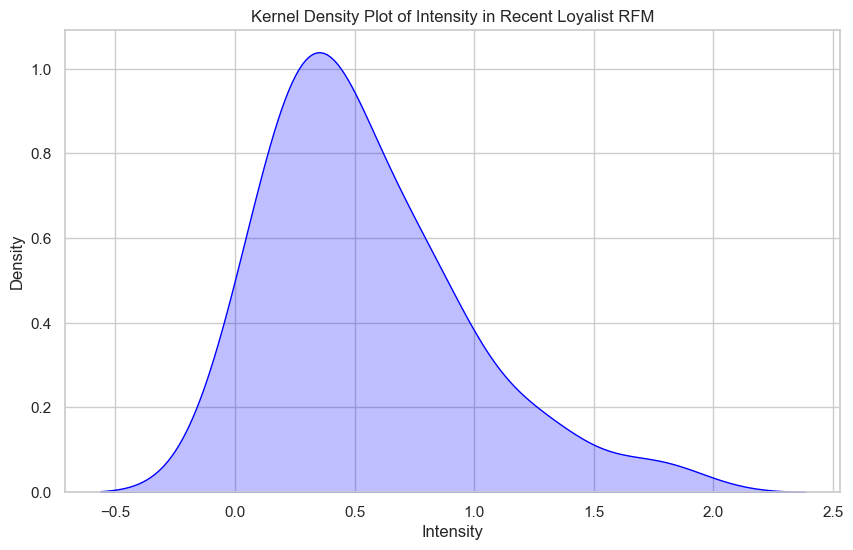

In [123]:
plt.figure(figsize=(10, 6))
sns.kdeplot(loyalist_rfm['intensity'], fill=True, color='blue')
plt.title('Kernel Density Plot of Intensity in Recent Loyalist RFM') #intensity measures high activity
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.show()



In [124]:
intense_loyalist_rfm = loyalist_rfm[loyalist_rfm['intensity'] > 0.417526]

In [125]:
intense_loyalist_rfm

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
8,Brain Embassy-PL-Warsaw,24,698,482,30368.67,359,0.200557,0.690544,loyalist
12,Luminary-US-NY-New York,24,403,709,71605.75,437,0.237986,1.759305,loyalist
16,Mindspace-DE-Hamburg,24,817,591,39407.03,414,0.202899,0.723378,loyalist
25,Mindspace-NL-Amsterdam,24,834,713,51045.18,514,0.157588,0.854916,loyalist
29,Mindspace-US-CA-San Francisco,27,761,343,29292.19,266,0.172932,0.450723,loyalist
30,Mindspace-US-DC-Washington,24,825,615,37886.30,470,0.189362,0.745455,loyalist
32,Nomadworks-US-NY-New York,25,709,908,65939.50,666,0.159159,1.280677,loyalist
45,The Yard-US-NY-Brooklyn,24,535,688,51423.50,531,0.171375,1.285981,loyalist
48,Urban Place-IL-Jerusalem,26,457,219,21368.38,120,0.275000,0.479212,loyalist
49,Urban Place-IL-Tel Aviv,26,463,375,31261.05,234,0.217949,0.809935,loyalist


In [126]:
recent_intense_loyalist_rfm = intense_loyalist_rfm[intense_loyalist_rfm['recency']==24]

In [127]:
recent_intense_loyalist_rfm

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,seg
8,Brain Embassy-PL-Warsaw,24,698,482,30368.67,359,0.200557,0.690544,loyalist
12,Luminary-US-NY-New York,24,403,709,71605.75,437,0.237986,1.759305,loyalist
16,Mindspace-DE-Hamburg,24,817,591,39407.03,414,0.202899,0.723378,loyalist
25,Mindspace-NL-Amsterdam,24,834,713,51045.18,514,0.157588,0.854916,loyalist
30,Mindspace-US-DC-Washington,24,825,615,37886.30,470,0.189362,0.745455,loyalist
45,The Yard-US-NY-Brooklyn,24,535,688,51423.50,531,0.171375,1.285981,loyalist


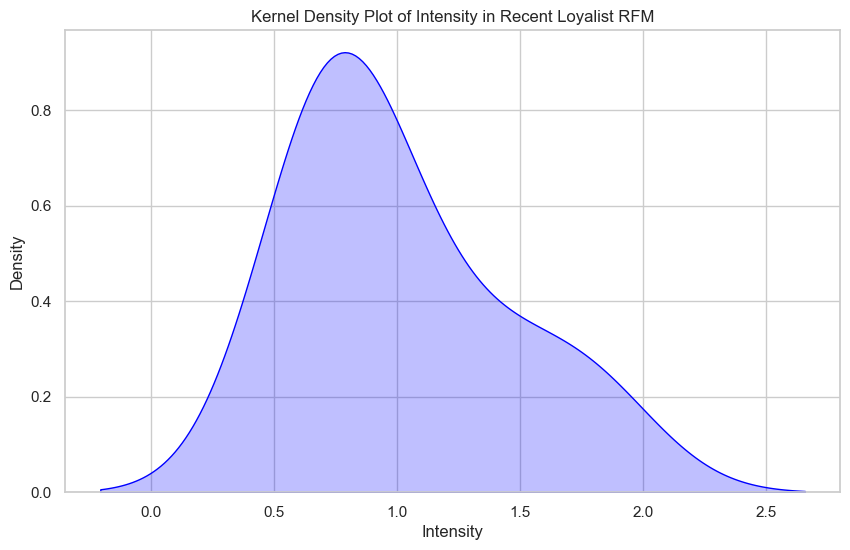

In [128]:
plt.figure(figsize=(10, 6))
sns.kdeplot(recent_intense_loyalist_rfm['intensity'], fill=True, color='blue')
plt.title('Kernel Density Plot of Intensity in Recent Loyalist RFM') #intensity measures high activity
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.show()

In [129]:
recent_intense_loyalist_rfm.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,24.0,685.333333,633.000000,46956.071667,454.166667,0.193294,1.009930
std,0.0,179.676005,89.543286,14551.123991,64.341019,0.027976,0.427987
min,24.0,403.000000,482.000000,30368.670000,359.000000,0.157588,0.690544
25%,24.0,575.750000,597.000000,38266.482500,419.750000,0.175871,0.728897
50%,24.0,757.500000,651.500000,45226.105000,453.500000,0.194959,0.800185
75%,24.0,823.000000,703.750000,51328.920000,503.000000,0.202313,1.178215
max,24.0,834.000000,713.000000,71605.750000,531.000000,0.237986,1.759305


In [139]:
luminary_date = fdf[fdf['operator_full_name'] == 'Luminary-US-NY-New York'][['date', 'operator_full_name']]

luminary_date['date'].max()


Timestamp('2023-06-30 00:00:00')

Mindspace-NL-Amsterdam is both loyal and highly engaged with a lifetime of almost 2 and a half years and among the other loyal operators has a high engagement with an intensity at 0.85. Luminary-Us-NY-New York is one to look out for, they are on track to being an incredible, loyal operator; they have the best return rate amongst the other highly loyal operators at 0.24, the most engaged operator,  and has brought in the most monetarily among the highly loyal operators. 

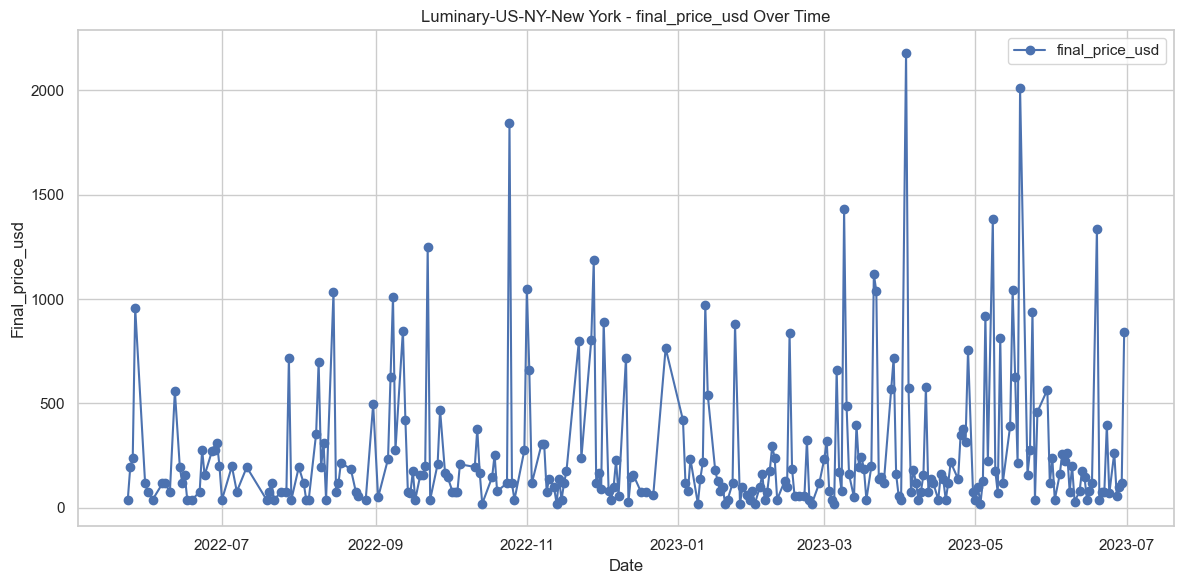

In [146]:
def plot_operator_behavior_by_month(fdf, operator_full_name, start_date=None, end_date=None, metric='final_price_usd'):
    
    # Filter the dataframe for the specific operator
    operator_data = fdf[fdf['operator_full_name'] == operator_full_name]
    
    # Ensure the 'date' column is of datetime type
    operator_data['date'] = pd.to_datetime(operator_data['date'])
    
    # If date range is specified, filter the data accordingly
    if start_date:
        operator_data = operator_data[operator_data['date'] >= start_date]
    if end_date:
        operator_data = operator_data[operator_data['date'] <= end_date]
    
    # Group by month and sum the metric
    grouped_data = operator_data.resample('M', on='date')[metric].sum().reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data['date'], grouped_data[metric], label=metric, linestyle='-')
    plt.title(f'{operator_full_name} - {metric} Over Time (Monthly)')
    plt.xlabel('Month')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot_operator_behavior(df, 'Mindspace-NL-Amsterdam', '2020-01-01', '2023-01-01', 'monetary')

plot_operator_behavior(fdf, 'Luminary-US-NY-New York', '2022-05-24', '2023-06-30', 'final_price_usd')


This is ugly and I want to change it.